#Montar el dataset

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive')
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
#https://www.kaggle.com/general/74235
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"juacami","key":"9cc4caf9890de37f285483e26b3cbd97"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!mkdir -p '/content/drive/MyDrive/IA proyecto'

In [ ]:
!kaggle datasets download -d ionutandreivaduva/garbage-classification

 63% 23.0M/36.4M [00:01<00:01, 9.86MB/s]
100% 36.4M/36.4M [00:01<00:00, 19.4MB/s]


In [ ]:
!mkdir -p '/content/drive/MyDrive/IA proyecto/garbage-classification'

In [ ]:
#Descomprimir
!unzip garbage-classification.zip -d '/content/drive/MyDrive/IA proyecto/garbage-classification'

#Librerias

In [ ]:
#@title Librerias
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
import pandas as pd
import os
import random

from tqdm import tqdm
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

#import pickle as pickle# Guardar datos

#Training, validacion y testeo



In [ ]:
#Montar datos

train_path = '/content/drive/MyDrive/IA proyecto/garbage-classification/Garbage Classification/train'
test_path = '/content/drive/MyDrive/IA proyecto/garbage-classification/Garbage Classification/test'

Image = [] # X

Label = [] # y

tipos = ["Metal", "Carton", "Plastico", "Vidrio"]
#Tamaño de las imagenes
imgsize = 224

def get_data(path_dataset):  
  for tipo in tqdm(tipos):
    path = os.path.join(path_dataset, tipo)
    clases = tipos.index(tipo)
    for img in os.listdir(path):
      img_a = cv.imread(os.path.join(path, img), cv.IMREAD_COLOR)
      img_a = cv.resize(img_a, (imgsize, imgsize))
      Image.append(np.array(img_a/255))
      Label.append(clases)

get_data(train_path)
get_data(test_path)

100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


In [ ]:
print(len(Image))

1921


Ejemplos de imagen


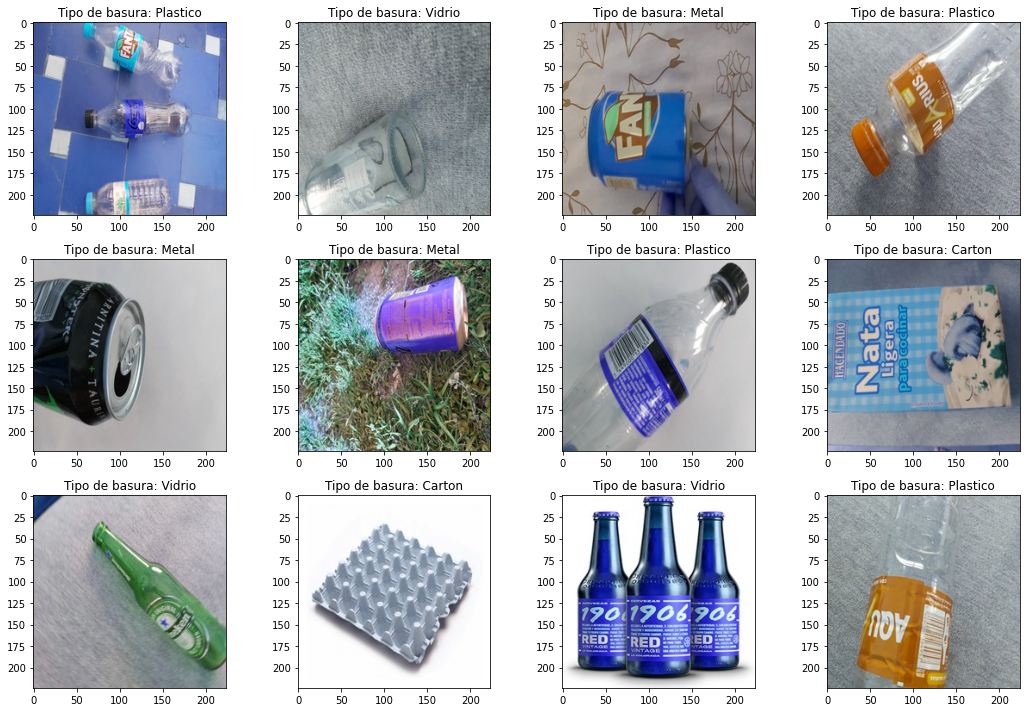

In [ ]:
print("Ejemplos de imagen")

fig, ax= plt.subplots(3,4)
fig.set_size_inches(15,10)

for i in range(3):
    for j in range (4):
        l = random.randint(0,len(Image))
        ax[i,j].imshow(Image[l])
        ax[i,j].set_title('Tipo de basura: '+ str(tipos[Label[l]]))
        
plt.tight_layout()

In [ ]:
from keras.utils.np_utils import to_categorical

y = to_categorical(Label, 4) #onhotencoder.
x = np.array(Image) 

# **Carga de imagenes en una escala de grises**

In [ ]:
imagen_gray = []
labels = list()
def get_data(path_dataset):  
  for tipo in tqdm(tipos):
    path = os.path.join(path_dataset, tipo)
    clases = tipos.index(tipo)
    for img in os.listdir(path):
      img_a = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
      img_a = cv.resize(img_a, (128, 128))
      imagen_gray.append(np.array(img_a/255))
      labels.append(clases)
get_data(train_path)
get_data(test_path)

100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


## **Función para redimensionar las imágenes a ancho x alto**

In [ ]:
imagenes = []
X_g = np.array(imagen_gray)
for i in range(X_g.shape[0]):
  dimension = np.array([])
  for fila in X_g[i,:]:
    dimension = np.concatenate((dimension, fila))
  imagenes.append([dimension])
imagenes = np.squeeze(imagenes)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
labels = np.array(labels) #onhotencoder.
X_train,X_test, Y_train, Y_test = train_test_split(imagenes,labels,test_size = 0.3, shuffle = True)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(1344, 16384) (577, 16384)
(1344,) (577,)


## **Creación del Modelo de clasificación con SVC**

In [ ]:
print(X_train.shape, Y_train.shape)

(1344, 16384) (1344,)


In [ ]:
from sklearn.svm import SVC
g = SVC(kernel='rbf')
g.fit(X_train, Y_train)
print( "acierto en train", g.score(X_train, Y_train))
print( "acierto en test ", g.score(X_test, Y_test))

predicciones_train = g.predict(X_train) #Puntaje de clasificación de entrenamiento
predicciones_test  = g.predict(X_test) #puntaje de clasificación de test



acierto en train 0.7708333333333334
acierto en test  0.5147313691507799


## **Resultados de la clasificación**

In [ ]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(Y_train, predicciones_train)
cm_test = confusion_matrix(Y_test, predicciones_test)
print( "Matriz de confusión en train\n", cm_train)
print("\n")
print ("Matriz de confusión en test\n", cm_test)
print( "verifica número de imágenes en total por fila")
print( np.sum(cm_test, axis=1))

Matriz de confusión en train
 [[258   3  41  12]
 [ 14 168  67  11]
 [ 18   4 384  11]
 [ 13   7 107 226]]


Matriz de confusión en test
 [[ 78  12  34  14]
 [ 18  34  37  12]
 [ 29  13 136  19]
 [ 29   3  60  49]]
verifica número de imágenes en total por fila
[138 101 197 141]


EL dropout, en cada capa lo que hace es apagar cierto numéro de neuronas durante el entrenamiento.

### **IMPLEMENTACIÓN DE UNA DNN**

# **Preprocesamiento de las Imágenes**

In [ ]:
from sklearn.model_selection import train_test_split


train_set = x.copy()
Y = np.array(Label)
X_train, X_test, Y_train, Y_test = train_test_split(train_set, Y, test_size = 0.3, shuffle =True)

In [ ]:
X_train = X_train.reshape([-1, 224, 224, 3])
X_test = X_test.reshape([-1, 224, 224, 3]) 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Y_test = tf.keras.utils.to_categorical(Y_test)
Y_train = tf.keras.utils.to_categorical(Y_train)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

model_DNN = Sequential()
model_DNN.add(Flatten(input_shape= [224,224,3]))
model_DNN.add(Dense(units = 64, activation='relu'))
model_DNN.add(Dense(units = 32, activation = 'relu'))
model_DNN.add(Dense(units = 32, activation = 'relu'))
model_DNN.add(Dense(units = 4, activation = 'softmax'))

model_DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                9633856   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 9,637,124
Trainable params: 9,637,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0014)
model_DNN.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

Epoch 1/100
42/42 [==============================] - 4s 36ms/step - loss: 19.1281 - accuracy: 0.2812 - val_loss: 6.5914 - val_accuracy: 0.2426
Epoch 2/100
42/42 [==============================] - 1s 22ms/step - loss: 5.4710 - accuracy: 0.3051 - val_loss: 2.7832 - val_accuracy: 0.3224
Epoch 3/100
42/42 [==============================] - 1s 21ms/step - loss: 2.9422 - accuracy: 0.3333 - val_loss: 3.7618 - val_accuracy: 0.3432
Epoch 4/100
42/42 [==============================] - 1s 21ms/step - loss: 1.9329 - accuracy: 0.4122 - val_loss: 2.0965 - val_accuracy: 0.4003
Epoch 5/100
42/42 [==============================] - 1s 21ms/step - loss: 2.5238 - accuracy: 0.3735 - val_loss: 1.3452 - val_accuracy: 0.4575
Epoch 6/100
42/42 [==============================] - 1s 21ms/step - loss: 1.3001 - accuracy: 0.4836 - val_loss: 1.3704 - val_accuracy: 0.4021
Epoch 7/100
42/42 [==============================] - 1s 21ms/step - loss: 1.5552 - accuracy: 0.4219 - val_loss: 1.4175 - val_accuracy: 0.4749
Epoch

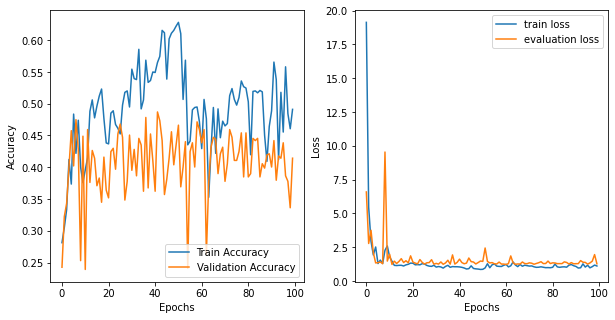

In [ ]:
import matplotlib.pyplot as plt
history = model_DNN.fit(X_train, Y_train, epochs=100, verbose=True,validation_data=(X_test, Y_test))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

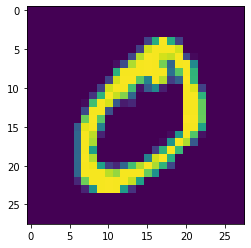

In [ ]:
import tensorflow 
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train.shape
plt.imshow(x_train[1])

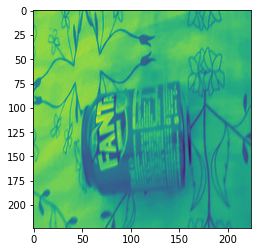

In [ ]:
for i in range(12):
  plt.imshow(X_g[19])

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

#Para ver imagenes en diferentes angulos

augs_gen = ImageDataGenerator(
        rotation_range=15,  
        horizontal_flip=True,  
        vertical_flip=True,
        zoom_range = 0.1) 


augs_gen.fit(x_train)

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


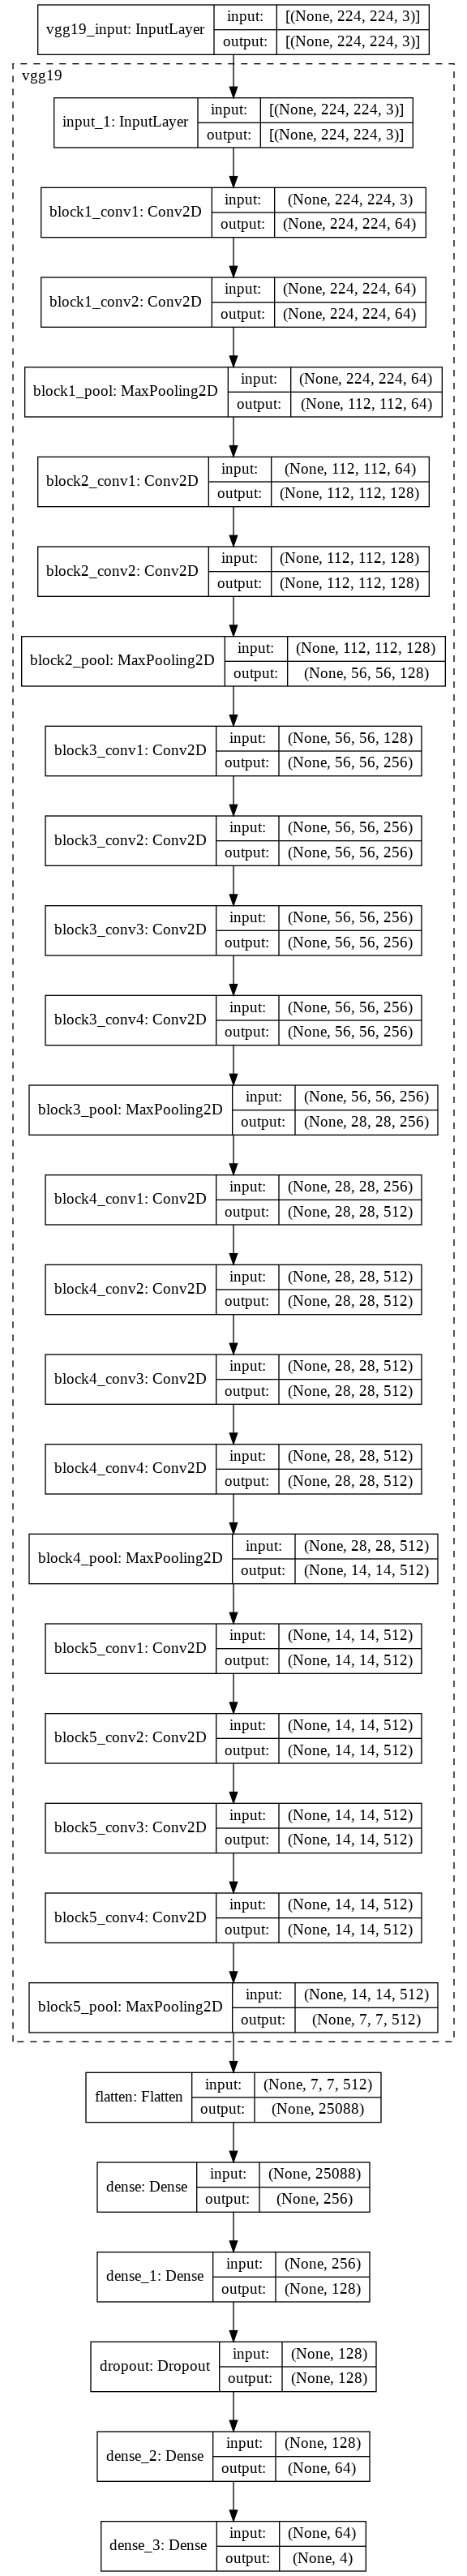

In [ ]:
#VGG19, es una red de clasificacion de imagenes preentrenada con el dataset imageNet.
#https://faroit.com/keras-docs/1.2.2/visualization/
#https://stackoverflow.com/questions/54307268/importerror-cannot-import-name-model-to-dot
#https://stackoverflow.com/questions/57405278/how-to-use-first-10-layers-of-pre-trained-model-like-vgg19-keras
#Congelar pesos, transfer learning: https://keras.io/guides/transfer_learning/

#output units Give the result on correlation of network units, and namelly is 
#mapped to a sofmax function to give a probability of each class. On MNIST 
#sample the output layer should be 10 because we have 10 classes.

#Use dropout to deal with overfitting

#Dense: https://medium.com/analytics-vidhya/dense-or-convolutional-part-1-c75c59c5b4ad
#Cantidad de nodos: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


from keras.applications.vgg19 import VGG19 
from keras.layers import MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model



imgsize = 224 
base_model = VGG19(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet') 


for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten()) 
model.add(Dense(256, activation='relu')) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(64, activation='relu'))
model.add(Dense(4,activation='softmax')) 
model.summary()

opt = tf.keras.optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy']) 

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
hist = model.fit(
    augs_gen.flow(x_train,y_train,batch_size=16),
    validation_data = augs_gen.flow(x_val,y_val, batch_size=16),
    epochs = 15
)

Epoch 1/15
84/84 [==============================] - 63s 342ms/step - loss: 2.0649 - accuracy: 0.2999 - val_loss: 1.2041 - val_accuracy: 0.4870
Epoch 2/15
84/84 [==============================] - 27s 326ms/step - loss: 1.2987 - accuracy: 0.4301 - val_loss: 1.0174 - val_accuracy: 0.5615
Epoch 3/15
84/84 [==============================] - 27s 327ms/step - loss: 1.1198 - accuracy: 0.5216 - val_loss: 1.0528 - val_accuracy: 0.4957
Epoch 4/15
84/84 [==============================] - 28s 328ms/step - loss: 0.9708 - accuracy: 0.6034 - val_loss: 0.7686 - val_accuracy: 0.7088
Epoch 5/15
84/84 [==============================] - 27s 326ms/step - loss: 0.9281 - accuracy: 0.6183 - val_loss: 0.7624 - val_accuracy: 0.7106
Epoch 6/15
84/84 [==============================] - 27s 327ms/step - loss: 0.8213 - accuracy: 0.6801 - val_loss: 0.7936 - val_accuracy: 0.6759
Epoch 7/15
84/84 [==============================] - 28s 329ms/step - loss: 0.7705 - accuracy: 0.7061 - val_loss: 0.8805 - val_accuracy: 0.6326

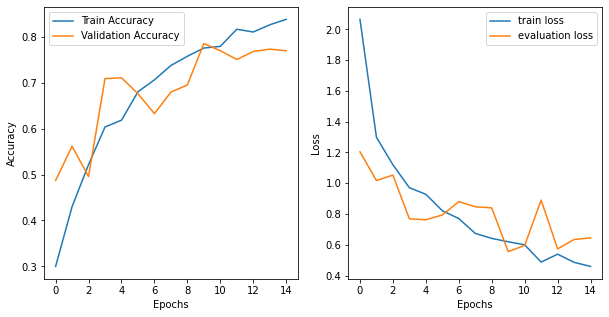

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist.history['accuracy'], label='Train Accuracy');
ax.plot(hist.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(hist.history['loss'], label='train loss');
ax.plot(hist.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
plt.figure(figsize=(30, 27))
list_img = np.random.randint(0,x_val.shape[0]-1,size=20)
for i,img_test in enumerate(x_val[list_img]):
  x = np.expand_dims(img_test, axis=0)
  predictions = model.predict(x)
  ax = plt.subplot(4, 5, i+1)
  plt.imshow(img_test)
  ax.set_title('Material REAL:' + tipos[np.argmax(y_val[list_img[i]])] + '\nMaterial PREDICHO: ' + tipos[np.argmax(predictions)] + '\n Porcentaje de acierto: '+ str(np.max(predictions)))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!sudo apt install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!git clone https://github.com/Contraltv/IdentificadorDeBasuras.git
%cd '/content/drive/MyDrive/IA proyecto/IdentificadorDeBasuras'

fatal: destination path 'IdentificadorDeBasuras' already exists and is not an empty directory.
/content/drive/MyDrive/IA proyecto/IdentificadorDeBasuras


In [ ]:
!git init https://github.com/Contraltv/IdentificadorDeBasuras.git

Initialized empty Git repository in /content/https:/github.com/Contraltv/IdentificadorDeBasuras.git/.git/


In [ ]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
!git add '/content/drive/MyDrive/IA proyecto'

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
